In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult
from utils import get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Configure Test

In [3]:
{"fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1","responseMoves":["Rxf7"],"saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],"solution":["Rxf7","Qxc7"]}

{'fen': '3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1',
 'responseMoves': ['Rxf7'],
 'saliencyGroundTruth': ['f1', 'h2', 'c3', 'e1', 'b3', 'h7', 'g3', 'g7'],
 'solution': ['Rxf7', 'Qxc7']}

In [25]:
FEN = "2r4k/3r1p1p/1p2pP2/p2pPp1P/P2P1Q2/6R1/4B1PK/2q5 w - - 0 1"
action = None
DISCOUNT_FACTOR = 0.9
DEPTH = 3

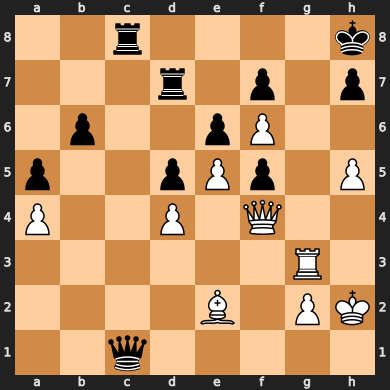

In [26]:
board = chess.Board(FEN)
board_visualization = BoardVisualization(board)
board_visualization.only_board()

# Algorithm Test

In [30]:
engine = Engine("./stockfish_15_x64_avx2")
saliency_results_per_step = []
moves_taken = []

def sequential_saliency_algorithm(fen, discount_factor, depth, runtime=2.0):
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
                optimal_move_q = sarfa_compute_result.optimal_move_q_val
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))
        
        saliency_results_per_step.append((saliency_results.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        optimal_move_obj = chess.Move.from_uci(optimal_move)
        moves_taken.append(optimal_move_obj)
        board.push(optimal_move_obj)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results

## 2 Seconds

In [36]:
saliency_results_per_step = []
moves_taken = []

saliency_results = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=5.0)

curr step: 0
Generated 34
perturbed board legal moves: 34
Generated 34
g3g8
{Move.from_uci('g3g8'), Move.from_uci('g3c3'), Move.from_uci('h2h3'), Move.from_uci('g3g4'), Move.from_uci('f4h6'), Move.from_uci('f4f5'), Move.from_uci('e2d3'), Move.from_uci('f4f3'), Move.from_uci('f4d2'), Move.from_uci('e2f3'), Move.from_uci('e2d1'), Move.from_uci('f4h4'), Move.from_uci('f4e3'), Move.from_uci('g3f3'), Move.from_uci('g3g6'), Move.from_uci('e2f1'), Move.from_uci('f4f1'), Move.from_uci('e2a6'), Move.from_uci('e2g4'), Move.from_uci('h5h6'), Move.from_uci('g3h3'), Move.from_uci('f4g4'), Move.from_uci('g3b3'), Move.from_uci('e2b5'), Move.from_uci('g3e3'), Move.from_uci('f4c1'), Move.from_uci('f4f2'), Move.from_uci('g3d3'), Move.from_uci('e2c4'), Move.from_uci('g3g7'), Move.from_uci('g3g5'), Move.from_uci('g3a3'), Move.from_uci('f4g5'), Move.from_uci('f4e4')}
before: {'g3g8': 6.29, 'f4c1': -0.62, 'f4h4': -3.7, 'f4f2': -3.86, 'f4f3': -4.7, 'f4f1': -5.44, 'g3f3': -5.87, 'g3e3': -6.27, 'f4g5': -7.18, 

KeyError: 'c8g8'

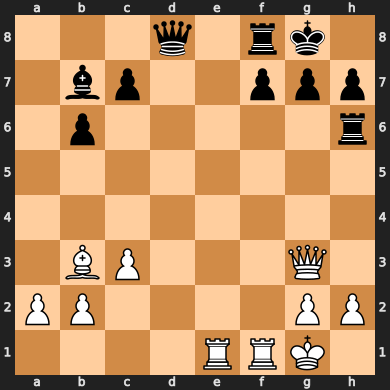

In [8]:
board

Important: 
["f1","h2","c3","e1","b3","h7","g3","g7"]

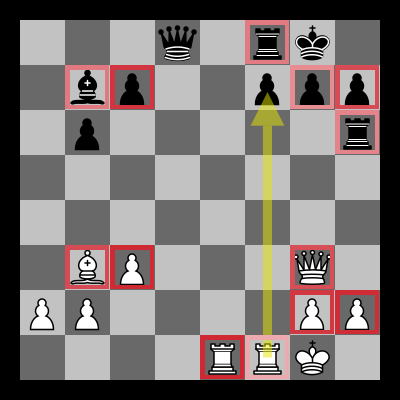

In [9]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

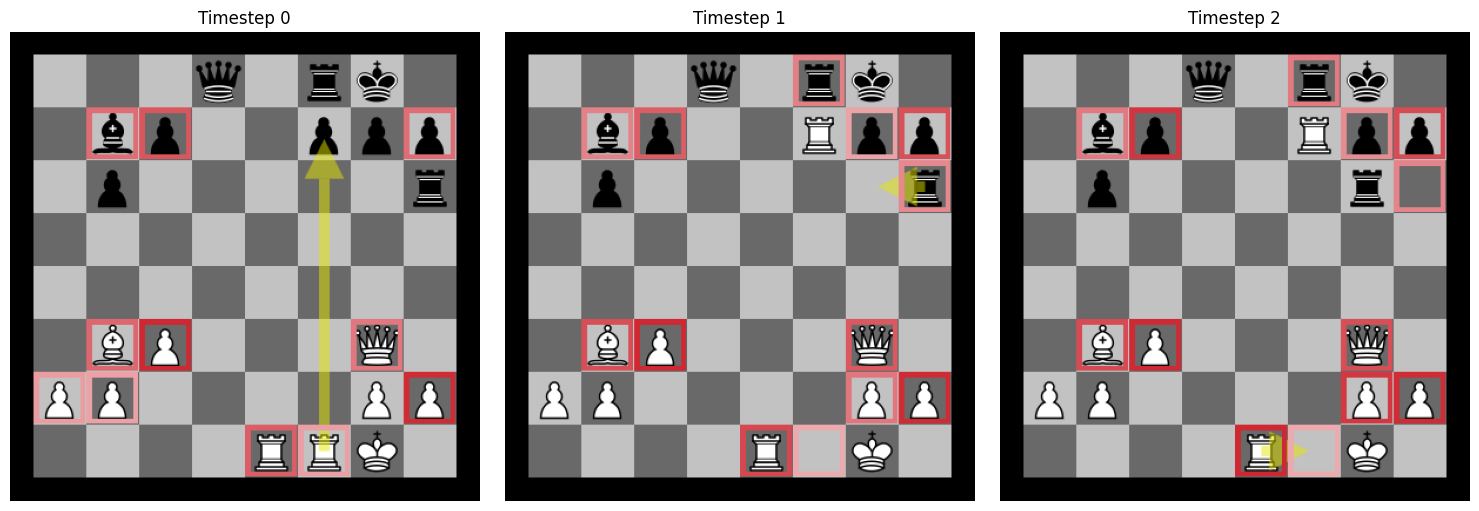

In [12]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Create a grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, DEPTH, figsize=(15, 5))  # Adjust the size as needed

# Loop through indices 1 through 3
for step in range(DEPTH):  # 1 through 3 inclusive
    board_visualization = BoardVisualization(saliency_results_per_step[step][1])
    path = board_visualization.show_heatmap(saliency_results_per_step[step][0], moves_taken[step])
    img = PILImage.open(path)
    
    # Display the image in the corresponding subplot
    axes[step].imshow(img)
    axes[step].axis('off')  # Turn off axis
    axes[step].set_title(f"Timestep {step}", fontsize=12)

# Adjust layout and show the grid
plt.tight_layout()
plt.show()


## 4 Seconds

In [13]:
saliency_results_per_step = []
moves_taken = []

saliency_results = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=4.0)

curr step: 0
curr step: 1
curr step: 2


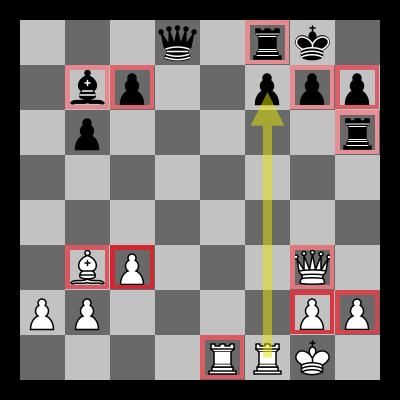

In [18]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

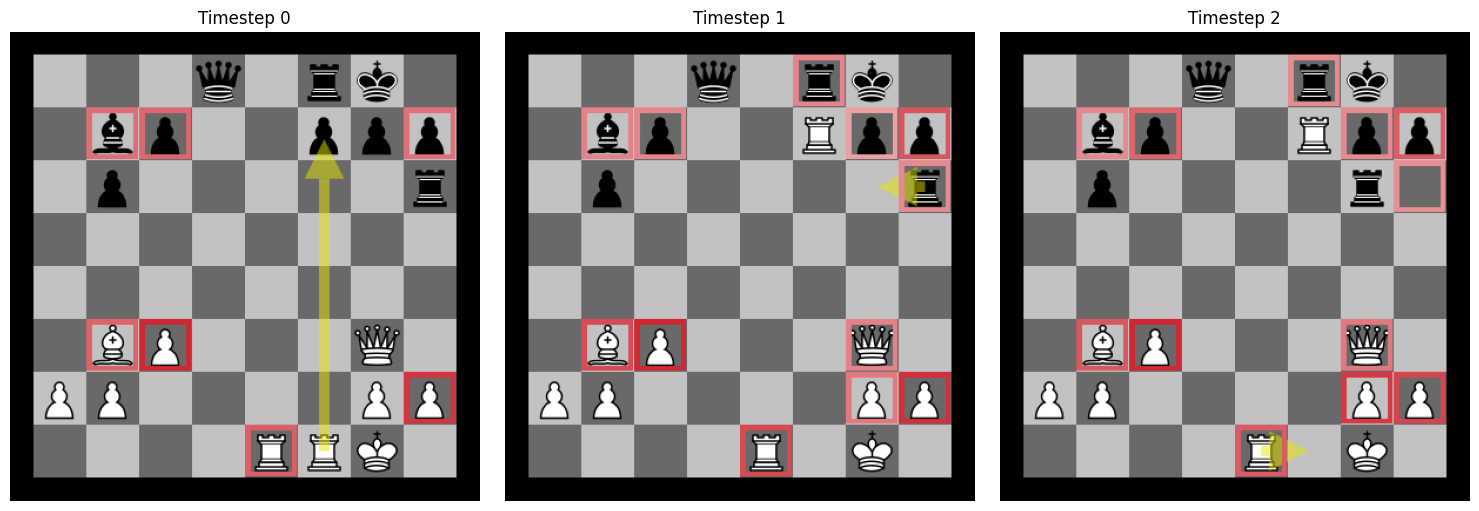

In [19]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Create a grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, DEPTH, figsize=(15, 5))  # Adjust the size as needed

# Loop through indices 1 through 3
for step in range(DEPTH):  # 1 through 3 inclusive
    board_visualization = BoardVisualization(saliency_results_per_step[step][1])
    path = board_visualization.show_heatmap(saliency_results_per_step[step][0], moves_taken[step])
    img = PILImage.open(path)
    
    # Display the image in the corresponding subplot
    axes[step].imshow(img)
    axes[step].axis('off')  # Turn off axis
    axes[step].set_title(f"Timestep {step}", fontsize=12)

# Adjust layout and show the grid
plt.tight_layout()
plt.show()


# Benchmark

In [20]:
from chess_dataset import SafraBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [24]:
sequential_benchmark_function = lambda x, _: sequential_saliency_algorithm(x, DISCOUNT_FACTOR, DEPTH, 2.0)
benchmark = SafraBenchmark(sequential_benchmark_function, sanity_check=True)

2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1
curr step: 0
c3d5
{Move.from_uci('g2c6'), Move.from_uci('c2e4'), Move.from_uci('g1h1'), Move.from_uci('h2h3'), Move.from_uci('f2f4'), Move.from_uci('c2b1'), Move.from_uci('b2a3'), Move.from_uci('g3g4'), Move.from_uci('h2h4'), Move.from_uci('g5e6'), Move.from_uci('c3b5'), Move.from_uci('g2e4'), Move.from_uci('c2c1'), Move.from_uci('d2d4'), Move.from_uci('g5h3'), Move.from_uci('g2d5'), Move.from_uci('b2a1'), Move.from_uci('g2h3'), Move.from_uci('g5f7'), Move.from_uci('g5f3'), Move.from_uci('c3b1'), Move.from_uci('c2g6'), Move.from_uci('d1c1'), Move.from_uci('g2f3'), Move.from_uci('e2e4'), Move.from_uci('d1b1'), Move.from_uci('g5h7'), Move.from_uci('c2f5'), Move.from_uci('d1e1'), Move.from_uci('c2d3'), Move.from_uci('c3e4'), Move.from_uci('f2f3'), Move.from_uci('g2h1'), Move.from_uci('b2c1'), Move.from_uci('g5e4'), Move.from_uci('c2h7'), Move.from_uci('f1e1'), Move.from_uci('c3d5'), Move.from_uci('d1a1'), Move.from_uci('c

KeyError: 'c8g8'

In [ ]:
benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7149651075498575}

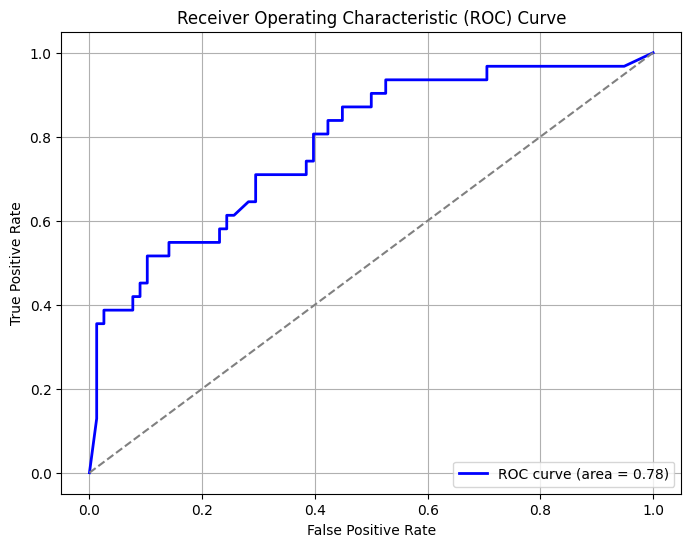

In [ ]:
fpr, tpr = benchmark.roc_curve()
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()